In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
print(tf.__version__)

2.0.0


### Creating synthetic data

In [2]:
TRUE_w = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

xs = tf.random.normal(shape=[NUM_EXAMPLES])
ys = (TRUE_w * xs) + TRUE_b

### create a custom model without inheriting the keras model class

In [3]:
class MyModel:
    def __init__(self):
        
        self.w = tf.Variable(tf.random.normal(()))
        self.b = tf.Variable(tf.zeros(()))
    
    def __call__(self,x):
        return self.w*x + self.b
    

### define a loss function

In [4]:
def loss(pred_y, target_y):
    return tf.reduce_mean(tf.square(pred_y-target_y))
    
myModel = MyModel()

### Before training

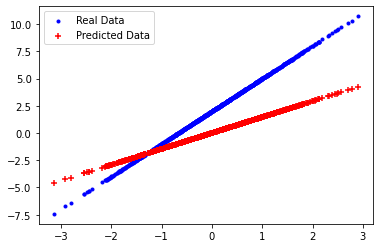

Current loss: 6.633862


In [5]:
def plot_data(inputs, outputs, predicted_outputs):
    real = plt.scatter(inputs, outputs, c='b', marker='.')
    predicted = plt.scatter(inputs, predicted_outputs, c='r', marker='+')
    plt.legend((real,predicted), ('Real Data', 'Predicted Data'))
    plt.show()
    
plot_data(xs, ys, myModel(xs))
print('Current loss: %1.6f' % loss(myModel(xs), ys).numpy())

### Train the model

In [6]:
def train(model,inputs,outputs,learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs),outputs)
        
    dw,db = t.gradient(current_loss,[model.w,model.b])
    
    model.w.assign_sub(learning_rate*dw)
    model.b.assign_sub(learning_rate*db)
    #Why below equation is not working?
    #model.w = model.w - learning_rate*dw
    #model.b = model.b - learning_rate*db
    
    return current_loss
     
list_w,list_b = [],[]
epochs = range(15)
losses = []

myModel = MyModel()

for epoch in epochs:
    list_w.append(myModel.w.numpy())
    list_b.append(myModel.b.numpy())
    current_loss = train(myModel,xs,ys,learning_rate=0.1)
    losses.append(current_loss)
    print('Epoch:',epoch,"W:",list_w[-1],"b:",list_b[-1],"Loss:",current_loss)

Epoch: 0 W: -0.7152488 b: 0.0 Loss: tf.Tensor(18.321203, shape=(), dtype=float32)
Epoch: 1 W: 0.036504924 b: 0.43564436 Loss: tf.Tensor(11.550373, shape=(), dtype=float32)
Epoch: 2 W: 0.63584965 b: 0.7769474 Loss: tf.Tensor(7.2836127, shape=(), dtype=float32)
Epoch: 3 W: 1.1137424 b: 1.0442398 Loss: tf.Tensor(4.594206, shape=(), dtype=float32)
Epoch: 4 W: 1.4948406 b: 1.2534887 Loss: tf.Tensor(2.8986192, shape=(), dtype=float32)
Epoch: 5 W: 1.7987871 b: 1.4172316 Loss: tf.Tensor(1.8293335, shape=(), dtype=float32)
Epoch: 6 W: 2.0412312 b: 1.5453098 Loss: tf.Tensor(1.1548352, shape=(), dtype=float32)
Epoch: 7 W: 2.2346416 b: 1.6454463 Loss: tf.Tensor(0.72925127, shape=(), dtype=float32)
Epoch: 8 W: 2.388955 b: 1.7236999 Loss: tf.Tensor(0.46064717, shape=(), dtype=float32)
Epoch: 9 W: 2.5120907 b: 1.7848223 Loss: tf.Tensor(0.29107055, shape=(), dtype=float32)
Epoch: 10 W: 2.6103601 b: 1.832539 Loss: tf.Tensor(0.18398038, shape=(), dtype=float32)
Epoch: 11 W: 2.688795 b: 1.8697695 Loss: t

### Evaluating trained model

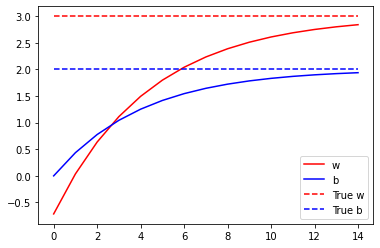

In [7]:
plt.plot(epochs, list_w, 'r',
       epochs, list_b, 'b')
plt.plot([TRUE_w] * len(epochs), 'r--',
      [TRUE_b] * len(epochs), 'b--')
plt.legend(['w', 'b', 'True w', 'True b'])
plt.show()

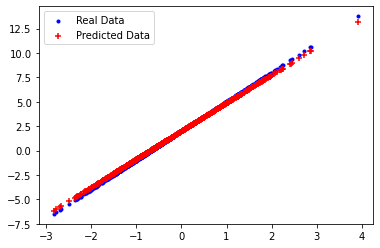

In [8]:
test_inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
test_outputs = test_inputs * TRUE_w + TRUE_b

predicted_test_outputs = myModel(test_inputs)
plot_data(test_inputs, test_outputs, predicted_test_outputs)

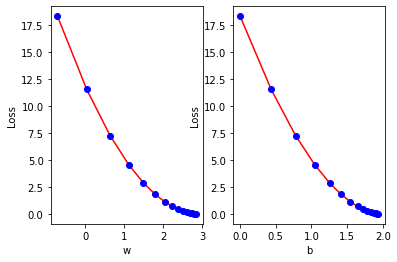

In [9]:
def plot_loss_for_weights(weights_list, losses):
  for idx, weights in enumerate(weights_list):
    plt.subplot(120 + idx + 1)
    plt.plot(weights['values'], losses, 'r')
    plt.plot(weights['values'], losses, 'bo')
    plt.xlabel(weights['name'])
    plt.ylabel('Loss')
    
    
weights_list = [{ 'name' : "w",
                  'values' : list_w
                },
                {
                  'name' : "b",
                  'values' : list_b
                }]

plot_loss_for_weights(weights_list, losses)

# Fashion MNIST - Custom training Loop

In [10]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
%matplotlib inline

### Prepare data

In [11]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir='data', download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='data', download=True)
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)

test =  test_data.batch(batch_size=batch_size)

In [12]:
def base_model():
    inputs = tf.keras.Input(shape=(784,), name='digits')
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

### Building training loop

In [13]:
def apply_gradient(optimizer, model, x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = loss_object(y_true=y, y_pred=logits)
  
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  
    return logits, loss_value

In [14]:
from tqdm import tqdm
def train_data_for_one_epoch():
    losses = []
    pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    for step, (x_batch_train, y_batch_train) in enumerate(train):
        logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
      
        losses.append(loss_value)
      
        train_acc_metric(y_batch_train, logits)
        pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
        pbar.update()
    return losses

In [15]:
def perform_validation():
    losses = []
    for x_val, y_val in test:
        val_logits = model(x_val)
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)
        val_acc_metric(y_val, val_logits)
    return losses

In [16]:
model = base_model()

# Iterate over epochs.
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
  
    losses_train = train_data_for_one_epoch()
    train_acc = train_acc_metric.result()

    losses_val = perform_validation()
    val_acc = val_acc_metric.result()

    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0


Training loss for step 937: 0.3065: 100%|████████████████████████████████████████████████████████████████████| 938/938 



 Epoch 0: Train loss: 0.5340  Validation Loss: 0.4357, Train Accuracy: 0.8152, Validation Accuracy 0.8463
Start of epoch 1


Training loss for step 937: 0.1606: 100%|███████████████████████████████████████████████████████████████████▉| 937/938 


 Epoch 1: Train loss: 0.3938  Validation Loss: 0.3991, Train Accuracy: 0.8593, Validation Accuracy 0.8589
Start of epoch 2


Training loss for step 937: 0.4545: 100%|████████████████████████████████████████████████████████████████████| 938/938 


 Epoch 2: Train loss: 0.3556  Validation Loss: 0.3804, Train Accuracy: 0.8722, Validation Accuracy 0.8628
Start of epoch 3


Training loss for step 937: 0.4545: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.2866: 100%|███████████████████████████████████████████████████████████████████▉| 937/938 


 Epoch 3: Train loss: 0.3319  Validation Loss: 0.3783, Train Accuracy: 0.8786, Validation Accuracy 0.8659
Start of epoch 4


Training loss for step 937: 0.2866: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.2342: 100%|███████████████████████████████████████████████████████████████████▉| 937/938 


 Epoch 4: Train loss: 0.3122  Validation Loss: 0.3660, Train Accuracy: 0.8862, Validation Accuracy 0.8737
Start of epoch 5


Training loss for step 937: 0.2342: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.1606: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.1811: 100%|███████████████████████████████████████████████████████████████████▉| 937/938 


 Epoch 5: Train loss: 0.2984  Validation Loss: 0.3510, Train Accuracy: 0.8906, Validation Accuracy 0.8759
Start of epoch 6


Training loss for step 937: 0.1811: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.2536: 100%|███████████████████████████████████████████████████████████████████▉| 937/938 


 Epoch 6: Train loss: 0.2863  Validation Loss: 0.3489, Train Accuracy: 0.8941, Validation Accuracy 0.8798
Start of epoch 7


Training loss for step 937: 0.2536: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.2025: 100%|███████████████████████████████████████████████████████████████████▉| 937/938 


 Epoch 7: Train loss: 0.2748  Validation Loss: 0.3514, Train Accuracy: 0.8973, Validation Accuracy 0.8775
Start of epoch 8


Training loss for step 937: 0.2025: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.4529: 100%|███████████████████████████████████████████████████████████████████▉| 937/938 


 Epoch 8: Train loss: 0.2651  Validation Loss: 0.3662, Train Accuracy: 0.9010, Validation Accuracy 0.8723
Start of epoch 9


Training loss for step 937: 0.4529: 100%|████████████████████████████████████████████████████████████████████| 938/938 
Training loss for step 937: 0.1788: 100%|███████████████████████████████████████████████████████████████████▉| 937/938 


 Epoch 9: Train loss: 0.2582  Validation Loss: 0.3378, Train Accuracy: 0.9041, Validation Accuracy 0.8836


### Evaluation

Training loss for step 937: 0.1788: 100%|████████████████████████████████████████████████████████████████████| 938/938 


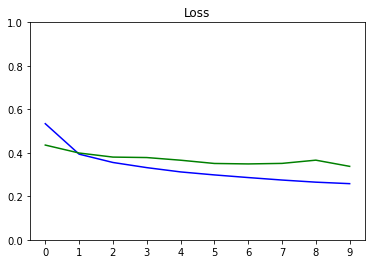

In [17]:
import matplotlib.ticker as mticker
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

In [18]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

    display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 
    
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], display_strings)
    plt.grid(None)
    image = np.reshape(image, [n, 28, 28])
    image = np.swapaxes(image, 0, 1)
    image = np.reshape(image, [28, 28*n])
    plt.imshow(image)

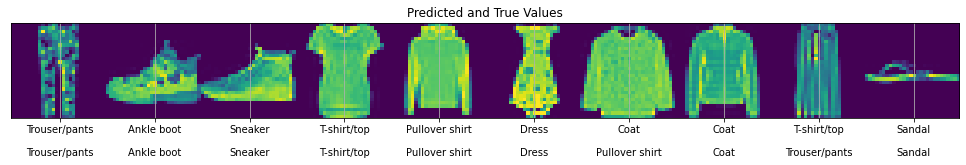

In [19]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
    y_pred = model(x)
    y_pred_batches = y_pred.numpy()
    y_true_batches = y.numpy()
    x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)